In [1]:
import numpy
import numpy as np
from numpy import log10, abs, pi
import scipy
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt


In [2]:
def plot_filter(coefs_m, legend_m, figfilename):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    for coefs in coefs_m:
        (w,H) = signal.freqz(coefs)
        ax1.plot(w, 20*log10(abs(H)))

    ax1.legend(legend_m)
    #bx = bands*2*pi
    #ax1.axvspan(bx[1], bx[2], facecolor='g', alpha=0.33)
    ax1.plot(pi/2, -6, 'go')
    ax1.axvline(pi/2, color='g', linestyle='--')
    ax1.axis([0,pi * 44e3/1.5e6,-64,3])
    #ax1.axis([0,pi,-64,3])
    ax1.grid(True)
    ax1.set_ylabel('Magnitude (dB)')
    ax1.set_xlabel('Normalized Frequency (radians)')
    ax1.set_title('Filter Frequency Response')
    fig.savefig(figfilename)
    #fig.show()

In [16]:
def export_header(identifier, b, filename):
    # export firwin-designed halfband filter to halfband.h
    # on pwm18i2 firwin gives slightly lower energy in  phantom frequencies 
    # above 9khz
    fu = open(filename, "w")
    fu.write(f'static constexpr int ALLTAPS = {len(b)};\n')
    fu.write('static constexpr float %s[]={\n' % identifier)
    for ii in range(len(b)):
        fu.write("%-1.8f,\n" % b[ii])
    fu.write("};")
    fu.close()

Full filter has this many taps: N+1= 911
ntrim= 214
But they have plenty of zeroes which we trim down to:  483


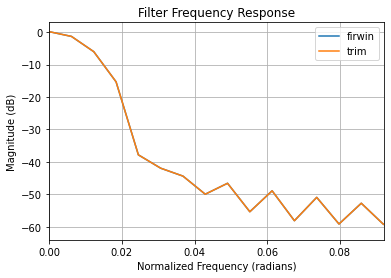

In [11]:
## ~~[Filter Design with Parks-McClellan Remez]~~
# half-band filter, 33 taps - used 6 times to bring down
# 1.5e6 down to 23437.5
#
# Both designs are okay, but firwin seems to win over remez
#
Fs=1.5e6
L = 5 # interpolation, UP
M = 156 # decimation, DOWN
#N = 1284 # 256 * L # is perfect but fat
#N = 128 * L # + firwin = almost perfect but a bit whistly on serduk
#N = 132 * L # + firwin = almost perfect but a bit whistly on serduk
#N = 152 * L # + firwin = almost perfect but a bit whistly on serduk
N = 182 * L # + firwin .7/M = whistle only heard after normalisation in atrocity

# ~~[Filter Design with Windowed freq]~~
fw = signal.firwin(N+1, .6/M, window=('kaiser', 7.8562))
#fw = signal.remez(N+1, [0, 0.7/M, 1./M, 0.5], [1,0], [1,1])
#fw[abs(fw) <= 1e-6] = 0.
fw[abs(fw) <= 1e-4] = 0.
#print(fw)
print("Full filter has this many taps: N+1=", N+1)
# originally 214
ntrim = 0
for i in range(len(fw)):
    if fw[i] != 0:
        break
    ntrim += 1
print("ntrim=", ntrim)
trim=fw[ntrim:len(fw)-ntrim]
#print("Trim zeroes to: ", ntrim)
plot_filter([fw,trim], ['firwin','trim'], 'interp.png')
print("But they have plenty of zeroes which we trim down to: ", len(trim))
#export_header('coefs', trim, 'interp.h')


total:  483 488
range:  97
range:  97
range:  97
range:  97
range:  97
sums= [0.20312968172819504, 0.20313099471948026, 0.20312968172819498, 0.20302921393329754, 0.2030292139332975] avg= 0.20302921393329754
comp= [0.9995054007172032, 0.9994989401478426, 0.9995054007172035, 1.0, 1.0000000000000002]
compensated:  0.2030292139332974
compensated:  0.2030292139332975
compensated:  0.20302921393329762
compensated:  0.20302921393329754
compensated:  0.20302921393329754
Lengths in the bank: [97, 97, 97, 97, 97]
483


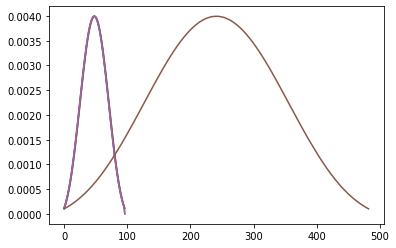

In [14]:
def make_filterbank(taps, UP):
    filterbank=[]
    #padding = [0] * UP
    #print(len(taps))
    padded=np.concatenate([taps, np.zeros(UP)])
    #padded = taps
    print("total: ", len(taps), len(padded))
    for phase in range(0,UP):
        print("range: ", len(list(range(phase, phase + len(taps), UP))))
        
        filterbank.append([padded[i] for i in range(phase, phase + len(taps), UP)])
    return filterbank

# work with trimmed filter
fw = trim

filterbank = make_filterbank(fw, L)
sums = [sum(x) for x in filterbank]
avg = sum(sums)/len(sums)
avg = 0.20302921393329754
compensation = [avg/s for s in sums]
print("sums=", sums, "avg=", avg)
print("comp=", compensation)
    
#np.array(filterbank[0]) * 2
compensated_filterbank=[]
for i,k in enumerate(compensation):
    comp = np.array(filterbank[i]) * k
    compensated_filterbank.append(comp)
    print("compensated: ", sum(comp))

for f in compensated_filterbank:
    plt.plot(f)

print("Lengths in the bank:", [len(x) for x in compensated_filterbank])
# put it back together
taps=[]
for k in range(len(compensated_filterbank[1])):
    for phase in range(L):
        taps.append(compensated_filterbank[phase][k])
taps=taps[:len(fw)]
plt.plot(taps)
print(len(taps))
    

In [17]:
export_header('coefs', taps, 'interp.h')